### Import packages

In [22]:
import os
import pathlib
import pickle
import json
import pandas as pd
from dtv_backend.lock import Locks
#import mdates
import matplotlib.dates as mdates


## Laad sluis informatie van de twee simulaties. Let op: pas path aan

In [23]:
df_met_afzetting = pd.read_csv('output/plots_routes/locks_afzetting_True.csv', parse_dates=['Timestamp'])
df_zonder_afzetting = pd.read_csv('output/plots_routes/locks_afzetting_False.csv', parse_dates=['Timestamp'])


#### Lees ook de informatie uit zenedo in.

In [24]:
locks_gdf = Locks(env=None).locks_gdf
locks_gdf_dict = locks_gdf.set_index('Id')['Name'].to_dict()
locks_gdf[locks_gdf.Name.str.contains('Andries')]

KeyboardInterrupt: 

## Bereken hoeveel schepen er maximaal bij een sluis komen op een dag

In [ ]:
def get_maximale_vaarverkeer_per_sluis(df_zonder_afzetting, df_met_afzetting):
    """Bepaal het vaarverkeer per sluis op de drukste dag en bereken het verschil tussen vaarverkeer met en zonder afzettingen.
    """
    #bepaal dag van elke message
    df_zonder_afzetting['dag']=df_zonder_afzetting.Timestamp.dt.date
    df_met_afzetting['dag']=df_met_afzetting.Timestamp.dt.date

    #bepaal aantal schepen per dag per sluis
    count_ships_zonder = df_zonder_afzetting[df_zonder_afzetting.Message.str.contains('enters queue for chamber')].groupby(['name', 'dag'])['Message'].count()
    count_ships_met = df_met_afzetting[df_met_afzetting.Message.str.contains('enters queue for chamber')].groupby(['name', 'dag'])['Message'].count()

    #voeg dataframes samen
    count_ships = pd.concat([count_ships_zonder, count_ships_met], axis=1, keys=['zonder', 'met']).fillna(0)

    # bereken maximale hoeveelheid schepen op een dag per sluis
    count_ships=count_ships.reset_index().groupby('name').max().drop('dag', axis=1)

    # bereken verschil in aantal schepen
    count_ships['verschil [%]'] = (count_ships['met'] - count_ships['zonder']) / count_ships['zonder'] * 100
    count_ships['verschil [-]'] = count_ships['met'] - count_ships['zonder']

    # drop infinity
    count_ships = count_ships.replace([float('inf'), float('-inf')], 0)
    count_ships.sort_values(by=['met','zonder'], ascending=False)
    return count_ships

count_ships = get_maximale_vaarverkeer_per_sluis(df_zonder_afzetting, df_met_afzetting)
count_ships[count_ships.index.str.contains('Andries')]

,zonder,met,verschil [%],verschil [-]
name,,,,
Anita Andriessensluis_0,9.0,9.0,0.000000,0.0
sluis St. Andries_Sluiskolk Sluis St. Andries,11.0,30.0,172.727273,19.0


## Bereken de lengte van wachtrijen bij sluizen

In [ ]:
def get_wachtrijen_voor_sluizen(df_zonder_afzetting, df_met_afzetting):
    """Bepaal de langst ontstane wachtrij per sluis."""
    queues_met_afzetting = df_met_afzetting[['name', 'queue_a', 'queue_b']].groupby('name').max()
    queues_zonder_afzetting = df_zonder_afzetting[['name', 'queue_a', 'queue_b']].groupby('name').max()
    queues_all = pd.concat([queues_met_afzetting, queues_zonder_afzetting], axis=1, keys=['met_afzetting', 'zonder_afzetting'])
    queues_all['met_afzetting_totaal'] = queues_all['met_afzetting'].sum(axis=1)
    queues_all.index = [queues_all.index, queues_all.index.map(locks_gdf_dict)]
    queues_all.index.names = ['id', 'name']
    namen = queues_all.index.get_level_values('name')
    queues_all.sort_values(by=['met_afzetting_totaal'], ascending=False)
    return queues_all
queues_all = get_wachtrijen_voor_sluizen(df_zonder_afzetting, df_met_afzetting)
queues_all[queues_all.index.get_level_values('id').str.contains('Andries')]

met_afzetting          \
                                                         queue_a queue_b   
id                                            name                         
Anita Andriessensluis_0                       NaN            1.0     1.0   
sluis St. Andries_Sluiskolk Sluis St. Andries NaN            2.0     3.0   

                                                   zonder_afzetting          \
                                                            queue_a queue_b   
id                                            name                            
Anita Andriessensluis_0                       NaN               1.0     1.0   
sluis St. Andries_Sluiskolk Sluis St. Andries NaN               2.0     1.0   

                                                   met_afzetting_totaal  
                                                                         
id                                            name                       
Anita Andriessensluis_0                       NaN                   2.0  
sluis St. Andries_Sluiskolk Sluis St. Andries NaN                   5.0

## Plot de wachtrij van een sluis.

Pas 'lock = ... ' aan. Jouw tekst komt boven de afbeelding, dus zorg voor een duidelijke naam. De naam moet voorkomen in de df_met_afzettingen. 

D:\Users\ALPF\AppData\Local\Temp\ipykernel_17880\1532731933.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

D:\Users\ALPF\AppData\Local\Temp\ipykernel_17880\1532731933.py:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



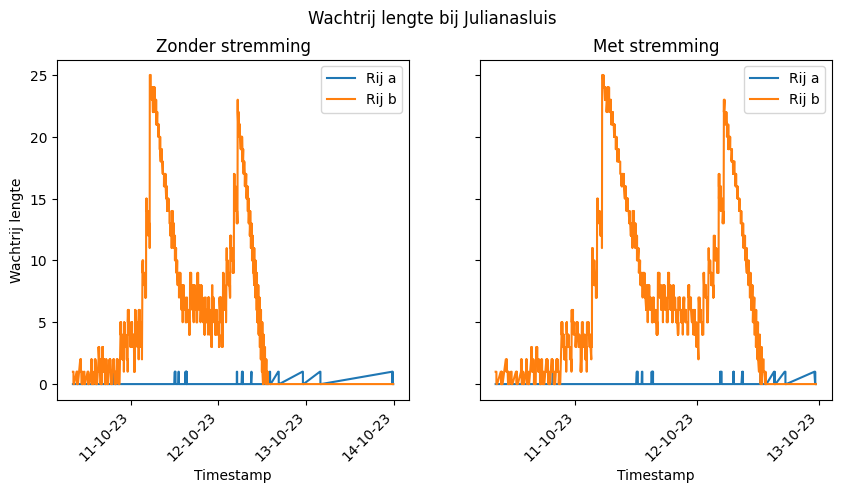

In [ ]:
import matplotlib.pyplot as plt
lock = 'Julianasluis'

def plot_wachtrijen(df_met_afzetting, df_zonder_afzetting, lock):
    df_met_afzetting_lock = df_met_afzetting[df_met_afzetting['name'].str.contains(lock)].set_index('Timestamp')
    df_zonder_afzetting_lock = df_zonder_afzetting[df_zonder_afzetting['name'].str.contains(lock)].set_index('Timestamp')
    fig, axs=plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    df_met_afzetting_lock.plot(y=['queue_a', 'queue_b'], ax=axs[1], title='Met stremming')
    axs[1].legend(['Rij a', 'Rij b'])
    df_zonder_afzetting_lock.plot(y=['queue_a', 'queue_b'], ax=axs[0], title='Zonder stremming')
    axs[0].legend(['Rij a', 'Rij b'])
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
    axs[0].set_ylabel('Wachtrij lengte')
    fig.suptitle('Wachtrij lengte bij {}'.format(lock))
    # round xlabel times to nearest hour
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    #only show every full day as label
    axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
    axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=1))
    return fig

fig = plot_wachtrijen(df_met_afzetting, df_zonder_afzetting, lock)

os.makedirs('output/analyse_lock_queues', exist_ok=True)
fig.savefig('output/analyse_lock_queues/{}.png'.format(lock))

## haal de log informatie van de schepen op

In [ ]:
import geopandas as gpd
def get_vessels_log():
    vessels_log_without_afzetting = gpd.read_file('output/plots_routes/trajectories_afzetting_False.gpkg')
    vessels_log_with_afzetting = gpd.read_file('output/plots_routes/trajectories_afzetting_True.gpkg')
    vessels_log_without_afzetting['t'] = pd.to_datetime(vessels_log_without_afzetting['t'], format='ISO8601', yearfirst=True)
    vessels_log_with_afzetting['t'] = pd.to_datetime(vessels_log_with_afzetting['t'], format='ISO8601', yearfirst=True)
    return vessels_log_without_afzetting, vessels_log_with_afzetting

vessels_log_with_afzetting, vessels_log_without_afzetting = get_vessels_log()
vessels_log_with_afzetting.head()

,Message,Value,trajectory_id,object_id,t,prev_t,geometry
0,Sailing to start,306.9304790979875,vessel_1000813_trip_1,vessel_1000813,2023-10-11 20:05:06.930000,2023-10-11T20:00:00,"LINESTRING (4.52639 52.14250, 4.53075 52.14185)"
1,Sailing from node 8866373 to node B13418_B sub...,0,vessel_1000813_trip_1,vessel_1000813,2023-10-11 20:05:38.169998,2023-10-11T20:05:06.930000,"LINESTRING (4.53075 52.14185, 4.53117 52.14174)"
2,Sailing from node 8866373 to node B13418_B sub...,0,vessel_1000813_trip_1,vessel_1000813,2023-10-11 20:06:52.348999,2023-10-11T20:05:38.169998,"LINESTRING (4.53117 52.14174, 4.53217 52.14149)"
3,Sailing from node 8866373 to node B13418_B sub...,0,vessel_1000813_trip_1,vessel_1000813,2023-10-11 20:07:57.363998,2023-10-11T20:06:52.348999,"LINESTRING (4.53217 52.14149, 4.53308 52.14131)"
4,Sailing from node 8866373 to node B13418_B sub...,0,vessel_1000813_trip_1,vessel_1000813,2023-10-11 20:08:53.542999,2023-10-11T20:07:57.363998,"LINESTRING (4.53308 52.14131, 4.53387 52.14118)"


## Maak een los geojson bestand van specifieke schepen. 

In [43]:
def create_gpd_from_vessel(id):
    selection_afzetting = vessels_log_with_afzetting[vessels_log_with_afzetting['object_id']==f'vessel_{id}']
    selection_without_afzetting = vessels_log_without_afzetting[vessels_log_without_afzetting['object_id']==f'vessel_{id}']

    data = pickle.load(open('data/ivs/ivs-2024-geocoded_filtered.pkl', 'rb'))
    unlo_from = data[data.name==id]['UNLO_herkomst'].iloc[0]
    unlo_to = data[data.name==id]['UNLO_bestemming'].iloc[0]

    dir_selection = f'output/graphs/from_{unlo_from}_to_{unlo_to}'
    os.makedirs(dir_selection, exist_ok=True)
    selection_afzetting.to_file(f'{dir_selection}/from_{unlo_from}_to_{unlo_to}_afzetting_TRUE.geojson', driver='GeoJSON')
    selection_without_afzetting.to_file(f'{dir_selection}/from_{unlo_from}_to_{unlo_to}_afzetting_FALSE.geojson', driver='GeoJSON')

for id in [79304, 1505366, 23257, 2325904, 1798207]:
    create_gpd_from_vessel(id)

## Haal vaartijden per schip op met en zonder stremming, en bereken verschil in vaartijd

In [25]:

def get_vessel_times_all(vessels_log_with_afzetting, vessels_log_without_afzetting):
    grouped_with_afzetting = vessels_log_with_afzetting.groupby('object_id')['t'].agg(['max', 'min'])
    grouped_with_afzetting['max'][grouped_with_afzetting['max']>pd.Timestamp('2023-10-13')] =pd.Timestamp('2023-10-13')
    grouped_with_afzetting['time'] = grouped_with_afzetting['max'] - grouped_with_afzetting['min']

    grouped_without_afzetting = vessels_log_without_afzetting.groupby('object_id')['t'].agg(['max', 'min'])
    grouped_without_afzetting['max'][grouped_without_afzetting['max']>pd.Timestamp('2023-10-13')] =pd.Timestamp('2023-10-13')
    grouped_without_afzetting['time'] = grouped_without_afzetting['max'] - grouped_without_afzetting['min']

    vessel_times_df = pd.concat([grouped_with_afzetting, grouped_without_afzetting], axis=1, keys=['met_afzetting', 'zonder_afzetting']).dropna()
    vessel_times_df['difference (h)'] = (vessel_times_df[('met_afzetting', 'max')] - vessel_times_df[('zonder_afzetting', 'max')]).dt.total_seconds()/60/60
    return vessel_times_df
vessel_times_df = get_vessel_times_all(vessels_log_with_afzetting, vessels_log_without_afzetting)

D:\Users\ALPF\AppData\Local\Temp\ipykernel_17880\3916828842.py:3: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


D:\Users\ALPF\AppData\Local\Temp\ipykernel_17880\3916828842.py:7: FutureWarning:

ChainedAssignmentError: behaviour will change i

In [26]:
vessel_times_df.to_csv('plots_routes/vessel_times.csv')
vessel_times_df

met_afzetting                             \
                                      max                        min   
object_id                                                              
vessel_1000813 2023-10-13 00:00:00.000000 2023-10-11 20:05:06.930000   
vessel_100092  2023-10-13 00:00:00.000000 2023-10-10 08:07:01.882000   
vessel_100094  2023-10-12 22:23:09.359000 2023-10-11 16:02:39.863998   
vessel_1006937 2023-10-12 02:44:08.544000 2023-10-10 19:46:30.966999   
vessel_1006939 2023-10-13 00:00:00.000000 2023-10-11 17:07:13.658000   
...                                   ...                        ...   
vessel_992768  2023-10-11 20:40:49.359001 2023-10-10 15:02:39.863998   
vessel_993701  2023-10-13 00:00:00.000000 2023-10-10 23:27:10.012000   
vessel_995200  2023-10-13 00:00:00.000000 2023-10-11 12:18:18.124001   
vessel_996105  2023-10-11 12:11:33.950001 2023-10-10 20:05:34.620998   
vessel_998437  2023-10-11 21:22:55.359001 2023-10-10 16:02:39.863998   

                                                zonder_afzetting  \
                                 time                        max   
object_id                                                          
vessel_1000813 1 days 03:54:53.070000 2023-10-13 00:00:00.000000   
vessel_100092  2 days 15:52:58.118000 2023-10-13 00:00:00.000000   
vessel_100094  1 days 06:20:29.495002 2023-10-12 23:41:46.234001   
vessel_1006937 1 days 06:57:37.577001 2023-10-12 02:44:08.544000   
vessel_1006939 1 days 06:52:46.342000 2023-10-13 00:00:00.000000   
...                               ...                        ...   
vessel_992768  1 days 05:38:09.495003 2023-10-13 00:00:00.000000   
vessel_993701  2 days 00:32:49.988000 2023-10-13 00:00:00.000000   
vessel_995200  1 days 11:41:41.875999 2023-10-13 00:00:00.000000   
vessel_996105  0 days 16:05:59.329003 2023-10-11 12:11:33.950001   
vessel_998437  1 days 05:20:15.495003 2023-10-13 00:00:00.000000   

                                                                  \
                                      min                   time   
object_id                                                          
vessel_1000813 2023-10-11 20:05:06.930000 1 days 03:54:53.070000   
vessel_100092  2023-10-10 08:07:01.882000 2 days 15:52:58.118000   
vessel_100094  2023-10-11 16:02:39.863998 1 days 07:39:06.370003   
vessel_1006937 2023-10-10 19:46:30.966999 1 days 06:57:37.577001   
vessel_1006939 2023-10-11 17:07:13.658000 1 days 06:52:46.342000   
...                                   ...                    ...   
vessel_992768  2023-10-10 15:02:39.863998 2 days 08:57:20.136002   
vessel_993701  2023-10-10 23:27:10.012000 2 days 00:32:49.988000   
vessel_995200  2023-10-11 12:18:18.124001 1 days 11:41:41.875999   
vessel_996105  2023-10-10 20:05:34.620998 0 days 16:05:59.329003   
vessel_998437  2023-10-10 16:02:39.863998 2 days 07:57:20.136002   

               difference (h)  
                               
object_id                      
vessel_1000813       0.000000  
vessel_100092        0.000000  
vessel_100094       -1.310243  
vessel_1006937       0.000000  
vessel_1006939       0.000000  
...                       ...  
vessel_992768      -27.319622  
vessel_993701        0.000000  
vessel_995200        0.000000  
vessel_996105        0.000000  
vessel_998437      -26.617956  

[1891 rows x 7 columns]

## Plot de extra vaartijd die schepen hebben door de stremming

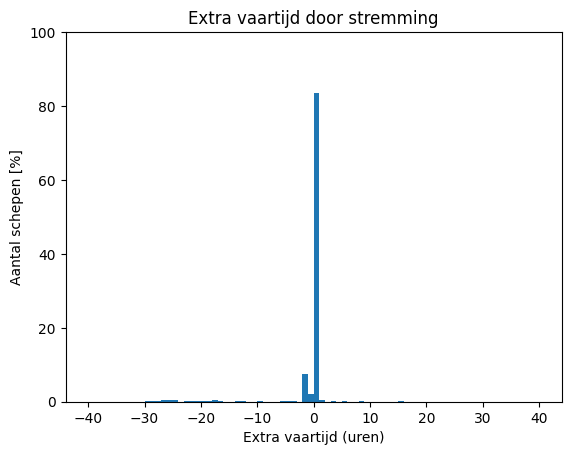

In [27]:
import numpy as np

data = vessel_times_df['difference (h)']
data.plot(kind='hist', weights=np.ones(len(data)) / len(data)*100, bins=80, title='Extra vaartijd door stremming', ylabel='Aantal schepen [%]', xlabel='Extra vaartijd (uren)', range=(-40,40))
plt.ylim(0, 100)
plt.savefig('output/extra_time/extra_vaartijd_stremming.png')


### Schatten hoeveel schepen ongeveer geen goede route meer vinden door de stremming. Dit is een bug die moet worden opgelost

Het aantal schepen dat aankomt voor 14 oktober zonder stremming nemen we als 100 %. Dit zijn 443 schepen. 
Het aantal schepen dat hiervan meer dan 5 uur vertraging heeft zou weleens te ver om kunnen varen. Dit zijn er 17. 

Deze statistieken zijn niet heel gegrond, maar zorgen voor een schatting van ongeveer 5 procent

Er komen ook ongeveer 140 schepen extra langs de Nieuwe Meerschutsluis. Dit is ongeveer 7 procent van de schepen. 

In [89]:
selection_komt_optijd_aan = vessel_times_df[('zonder_afzetting', 'max')]<pd.Timestamp('2023-10-12 18:00:00')
selection_veel_vertraging = vessel_times_df['difference (h)']>5
print(selection_komt_optijd_aan.sum())
print((selection_komt_optijd_aan&selection_veel_vertraging).sum())


443
17
7.000000000000001


## Bepaal extra vaartijd per vaartraject

In [331]:

import pickle
vessel_times_df = get_vessel_times_all(vessels_log_with_afzetting, vessels_log_without_afzetting)
vessel_times_df['name'] = vessel_times_df.index.str.removeprefix('vessel_').astype(int)
vessel_times_df = vessel_times_df.set_index('name')
vessel_data = pickle.load(open('data/ivs/ivs-2024-geocoded_filtered.pkl', 'rb'))
vessels_met_herkomst = pd.concat([vessel_times_df, vessel_data[['UNLO_herkomst', 'UNLO_bestemming']]], axis=1)
vessels_met_herkomst.groupby(['UNLO_herkomst', 'UNLO_bestemming'])[['difference (h)', '']].agg(['mean', 'count']).round(0).sort_values(by = [('difference (h)', '')], ascending=False)
vessels_met_herkomst.columns = ['extra tijd (h)']

os.makedirs('output/extra_time', exist_ok=True)
vessels_met_herkomst.reset_index().to_csv('output/extra_time/extra_time_per_location.csv')
vessels_met_herkomst

ValueError: 'object_id' is both an index level and a column label, which is ambiguous.